# Funções Base

In [17]:
from matplotlib.pyplot import *
import numpy as np
import h5py
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
import sklearn
%load_ext autoreload
from skimage import feature
import scipy
from skimage.filters import gabor
from skimage.filters import threshold_otsu

from skimage.filters import threshold_isodata
from skimage.morphology import erosion, disk,square, closing


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts - w))

def find_index(wavelenghts,w):
    return np.argmin(np.abs(wavelenghts - w))

In [3]:
def read_data_map(file):
    hf = h5py.File(file, 'r')
    spectrums = np.array(hf.get('intensities'))
    positions = np.array(hf.get('position'))
    wavelengths = np.array(hf.get('wavelengths'))
    positions = np.delete(positions, 0, 0)
    spectrums = np.delete(spectrums, 0, 0)
    x = positions[:, 0]
    y = positions[:, 1]
    xy = np.lexsort((y, x))

    hf.close()
    return spectrums[xy], wavelengths, positions

# 1.0 LIBS

## com os dados hdr

## 1.1 Deteção de Elementos

In [4]:
file='C:/Users/Joana/Documents/Doutoramento/1 ano/spectral imaging/HDR/Comparação libs_raman/hdr_petalite_espodumeno.h5'
def read_data_map_2(file):
    # Open the HDF5 file in read mode
    with h5py.File(file, 'r') as hf:
        # Extract the datasets and convert them to numpy arrays
        spectrums = np.array(hf.get('intensities'))
        positions = np.array(hf.get('position'))
        wavelengths = np.array(hf.get('wavelengths'))

    # Return the data as is
    return spectrums, wavelengths, positions
spectrum, wavelengths, positions = read_data_map_2(file)

In [5]:
el=[610.22,588.99,309.27,288.13,777.194]
el_n=['Li','Na','Al','Si','O']

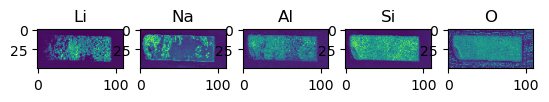

In [6]:
maps=spectrum.copy()
fig,ax=subplots(1,len(el))
for i in range(len(el)):
    ax[i].imshow(maps[find_index(wavelengths,el[i]),:,:])
    ax[i].set_title(el_n[i])

In [190]:
normalized_spec1=np.transpose(maps.reshape(-1,maps.shape[1],maps.shape[2]),axes=(1,2,0))

nx, ny = normalized_spec1.shape[1], normalized_spec1.shape[0]
dx = 0.5
dy = 0.5
 
freqs_x = 2*np.pi*np.fft.fftfreq(nx, dx)
freqs_y = 2*np.pi*np.fft.fftfreq(ny, dy)
 
def fft_feature(mmap, pixel_size_small):
    fft_map = np.array([np.fft.fftshift(np.fft.fft2(mmap[:, :, i])) for i in tqdm(range(0, (mmap.shape[-1])))])
    fft_map[:, fft_map.shape[1]//2, fft_map.shape[2]//2] = 0
 
    kxx, kyy = np.meshgrid(np.fft.fftshift(freqs_x), np.fft.fftshift(freqs_y))
 
    object_size_small = pixel_size_small*dx
    size_kspace_small = 2*np.pi/object_size_small/2*1.5
 
    R = abs(np.sqrt(kxx**2 + kyy**2))
 
    sum1 = np.sum(np.abs(fft_map[:,(R < size_kspace_small)]), axis = (1))
    max1 = np.sum(np.abs(fft_map), axis = (1, 2))
 
    sums = np.array(sum1)/np.array(max1)
 
    return sums, fft_map
 
sums, fft_m = fft_feature(normalized_spec1, 10)

100%|██████████| 16384/16384 [00:04<00:00, 3633.29it/s]


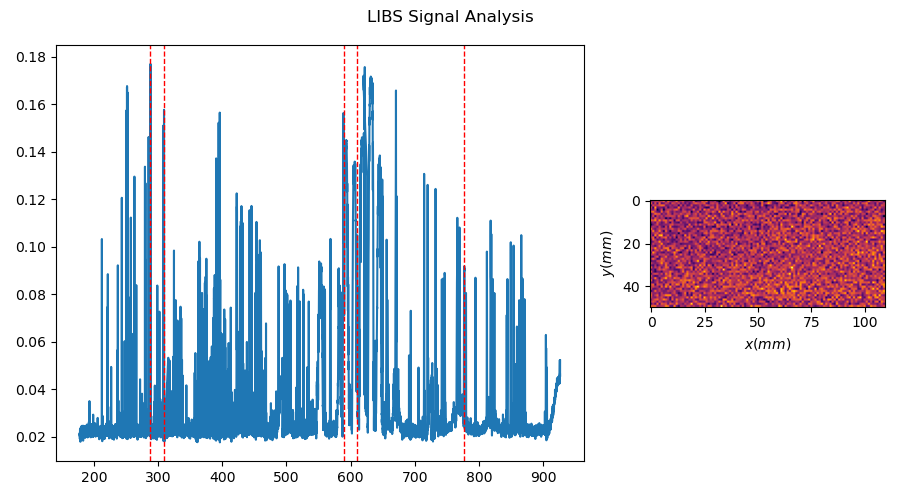

In [191]:

find_index = lambda wavelenghts,w : np.argmin(np.abs(wavelengths-w))
    
%matplotlib widget
fig, ax = subplots(1,2, figsize = (9, 5), gridspec_kw = {'width_ratios': [0.9, 0.4]})
fig.suptitle('LIBS Signal Analysis')

axs = ax[0]
axs.plot(wavelengths,sums)
for i in range(len(el)):
    axs.axvline(el[i],linestyle='--',color='red',lw=1)
axs = ax[1]
axs.imshow(maps[100,:, :], cmap = cm.inferno)
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')



def update_map(wn):
    im = ax[1].imshow(maps[wn,:, :],
                     interpolation = 'none')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths, ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

In [192]:
peaks=scipy.signal.find_peaks(sums)[0]
sel_maps=[]
sel_wavs=[]
heights=sums[peaks]
for i in range(len(peaks)):
    if heights[i]>0.11:
        sel_maps.append(maps[peaks[i]])
        sel_wavs.append([wavelengths[peaks[i]]])

sel_maps=np.array(sel_maps)
sel_maps=sel_maps.reshape(-1,maps.shape[1],maps.shape[2])

In [193]:
# para os mapas que estão dentro dos parametros da fft retirar os que tem sinal fora da rocha
sel_maps_f=sel_maps.reshape(-1,sel_maps.shape[1]*sel_maps.shape[2])
thresholds=np.array([threshold_otsu(sel_maps_f[i]) for i in range(sel_maps.shape[0])])
final_masks=[]
for map in range(len(thresholds)):
    c_mask=np.zeros(sel_maps_f.shape[1])
    for i in range(sel_maps_f.shape[1]):
        if sel_maps_f[map,i]>thresholds[map]:
            c_mask[i]=1
    final_masks.append(c_mask)

final_masks=np.array(final_masks).reshape(-1,sel_maps.shape[1],sel_maps.shape[2])


new_maps=[]
edge=[]
for w in tqdm(range(final_masks.shape[0])):
    current_map=final_masks[w,:,:]
    pixel_sum=np.sum(current_map[43:,:])
    if pixel_sum <1:
        new_maps.append(sel_maps[w,:,:])
new_maps=np.array(new_maps)
print(sel_maps.shape)
print(new_maps.shape)

100%|██████████| 180/180 [00:00<00:00, 22442.10it/s]

(180, 50, 110)
(22, 50, 110)


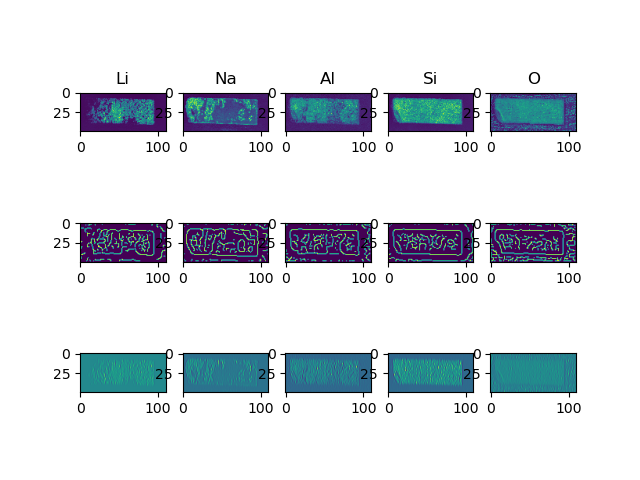

In [194]:
fig,ax=subplots(3,len(el))
for i in range(len(el)):
    c_map=maps[find_index(wavelengths,el[i]),:,:]
    ax[0,i].imshow(c_map)
    ax[0,i].set_title(el_n[i])
    ax[1,i].imshow(feature.canny(c_map*255,sigma=2))
    ax[2,i].imshow(gabor(c_map*255, frequency=0.6)[0])

In [195]:
edge_maps=[]
for w in tqdm(range(new_maps.shape[0])):
    current_map=new_maps[w,:,:]*255
    edges = feature.canny(current_map,sigma=1.5)
    edge_maps.append(edges)
edge_maps=np.array(edge_maps)
texture_maps=[]

for w in tqdm(range(new_maps.shape[0])):
    current_map=new_maps[w,:,:]
    filt_real, filt_imag = gabor(current_map, frequency=0.6) #lower f, more sensitivty to detail
    texture_maps.append(filt_real)
texture_maps=np.array(texture_maps)


  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 22/22 [00:00<00:00, 944.22it/s]


In [196]:
n_clusters=4
kmeans = sklearn.cluster.KMeans(n_clusters = n_clusters,random_state=0)
 
new_features=new_maps*500#+edge_maps*10+texture_maps*400
features=new_features.reshape(-1,maps.shape[2]*maps.shape[1])
a=kmeans.fit_predict(features)
labels = kmeans.labels_
clusters_c = np.array(kmeans.cluster_centers_)

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


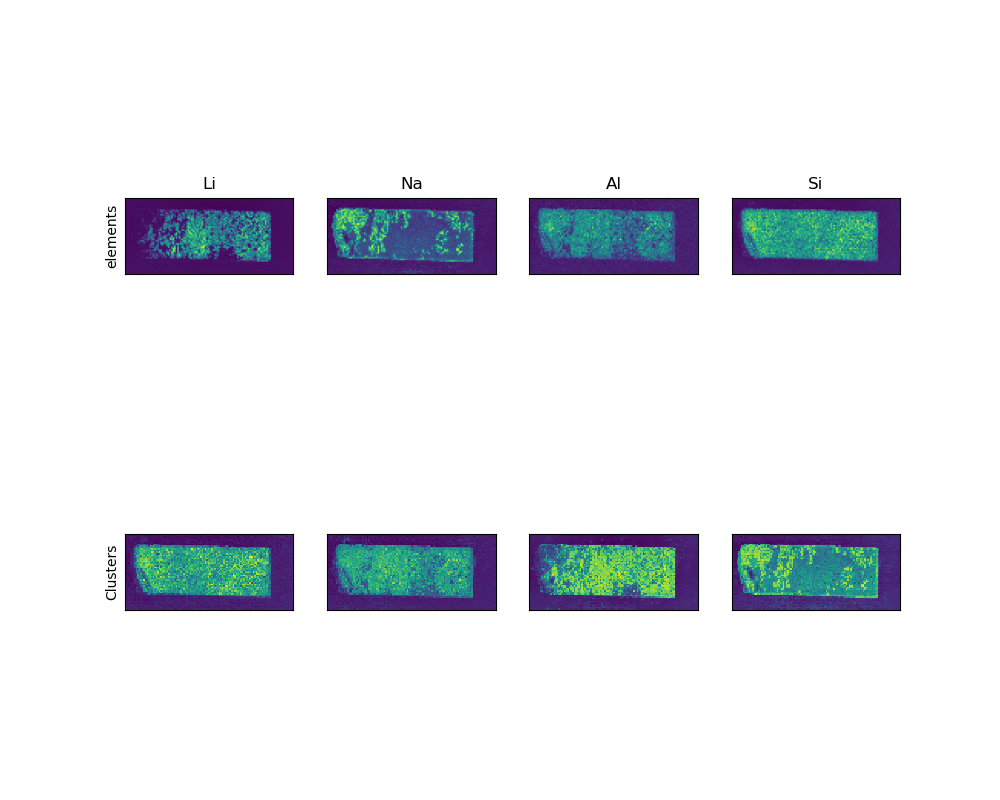

In [197]:
fig,ax=subplots(2,n_clusters,figsize=(10,8))
for i in range(n_clusters):
    if i<len(el):
        wav=find_index(wavelengths,el[i])
        ax[0,i].imshow(maps[wav,:,:])
        ax[0,i].set_title(el_n[i])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[0,0].set_ylabel('elements')
    ax[1,0].set_ylabel('Clusters')

    ax[1,i].imshow(clusters_c[i].reshape(maps.shape[1], maps.shape[2]), interpolation = 'none')

## 1.2 Identificação de minerais

### Thresholding

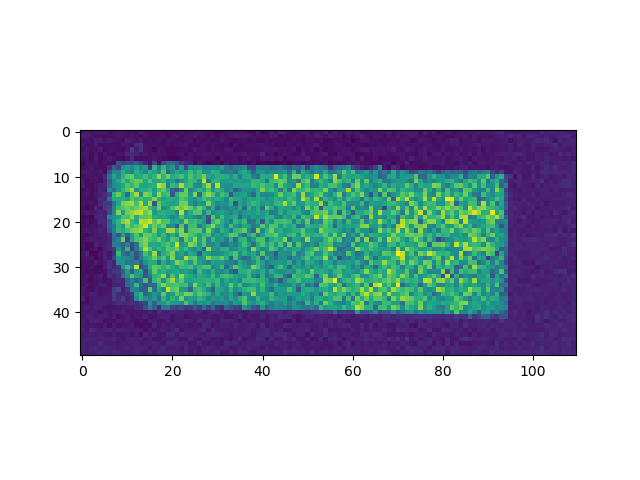

In [198]:
#definir area da imagem para thresholding
#cluster_label=['Al','Na','Si','O','Li']
cluster_label=['Si','Al','Li','Na']
clusters_reshaped=clusters_c.reshape(-1,maps.shape[1], maps.shape[2])
plt.figure()
plt.imshow(clusters_reshaped[0])


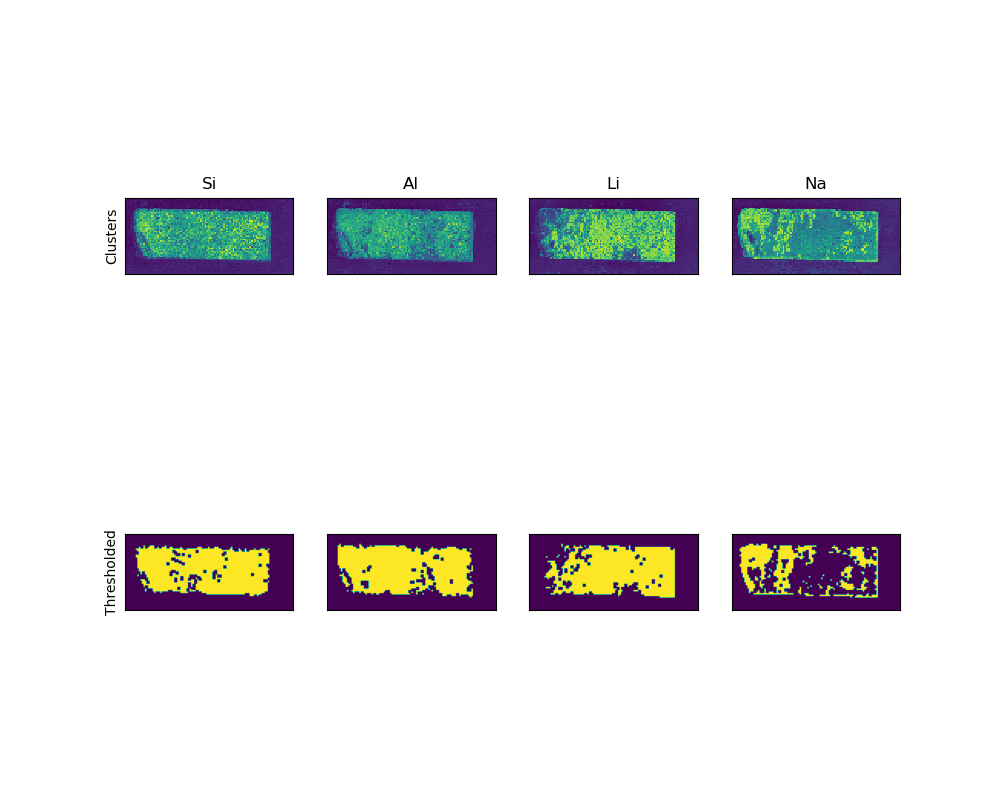

In [199]:
fig,ax=subplots(2,n_clusters,figsize=(10,8))
thresholded_clusters=[]

for i in range(n_clusters):
    ax[0,i].imshow(clusters_reshaped[i], interpolation = 'none')
    ax[0,i].set_title(cluster_label[i])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[0,0].set_ylabel('Clusters')


    t=threshold_otsu(clusters_reshaped[i,8:35,20:90])# a threshold tem de ser definida só dentro da amostra
    cluster_t=clusters_reshaped[i].copy()>t
    cleaned_map = erosion(cluster_t, square(1))
    cleaned_map = closing(cleaned_map, square(2))  # disk(2) or other sizes
    thresholded_clusters.append(cleaned_map)
    ax[1,i].imshow(cleaned_map)


    ax[1,0].set_ylabel('Thresholded')
thresholded_clusters=np.array(thresholded_clusters)

In [200]:
#todos os mapas sem background
sel_maps=maps

sel_maps_f=sel_maps.reshape(-1,sel_maps.shape[1]*sel_maps.shape[2])
thresholds=np.array([threshold_otsu(sel_maps_f[i]) for i in range(sel_maps.shape[0])])
final_masks=[]
for map in range(len(thresholds)):
    c_mask=np.zeros(sel_maps_f.shape[1])
    for i in range(sel_maps_f.shape[1]):
        if sel_maps_f[map,i]>thresholds[map]:
            c_mask[i]=1
    final_masks.append(c_mask)

final_masks=np.array(final_masks).reshape(-1,sel_maps.shape[1],sel_maps.shape[2])


new_maps=[]
edge=[]
for w in tqdm(range(sel_maps.shape[0])):
    current_map=final_masks[w,:,:]
    pixel_sum=np.sum(current_map[43:,:])
    if pixel_sum <1:
        new_maps.append(sel_maps[w,:,:])
new_maps=np.array(new_maps)
print(sel_maps.shape)
print(new_maps.shape)

100%|██████████| 16384/16384 [00:00<00:00, 108721.65it/s]

(16384, 50, 110)
(202, 50, 110)


In [201]:
## thresholding de todos os mapas

thresholds=np.array([threshold_otsu(new_maps[i,7:35,20:90]) for i in range(new_maps.shape[0])])
new_maps=new_maps.reshape(-1,new_maps.shape[1]*new_maps.shape[2])
maps_thres=[]
for i in range(new_maps.shape[0]):
    c_mask=np.zeros(new_maps.shape[1])
    for j in range(new_maps.shape[1]):
        if new_maps[i][j]>thresholds[i]:
            c_mask[j]=1
    maps_thres.append(c_mask)
maps_thres=np.array(maps_thres)  

In [202]:
maps_thres=maps_thres.reshape(-1,sel_maps.shape[1],sel_maps.shape[2])

In [203]:
for i in range(maps_thres.shape[0]):
    cleaned_map = erosion(maps_thres[i], square(1))
    cleaned_map = closing(cleaned_map, square(1))  # disk(2) or other sizes
    maps_thres[i]=cleaned_map
    

In [204]:
intersections_c=[]
cluster_groups=[]
for i in range(maps_thres.shape[0]):
    intersections=[]
    clusters_n=[]
    for j in range(thresholded_clusters.shape[0]):
        cont=np.sum(np.logical_and(maps_thres[i],thresholded_clusters[j]))/np.sum(maps_thres[i])
        intersections.append(cont)
        if cont>0.6:
            clusters_n.append(j)

    intersections_c.append(intersections)
    cluster_groups.append(clusters_n)
intersections_c=np.array(intersections_c)

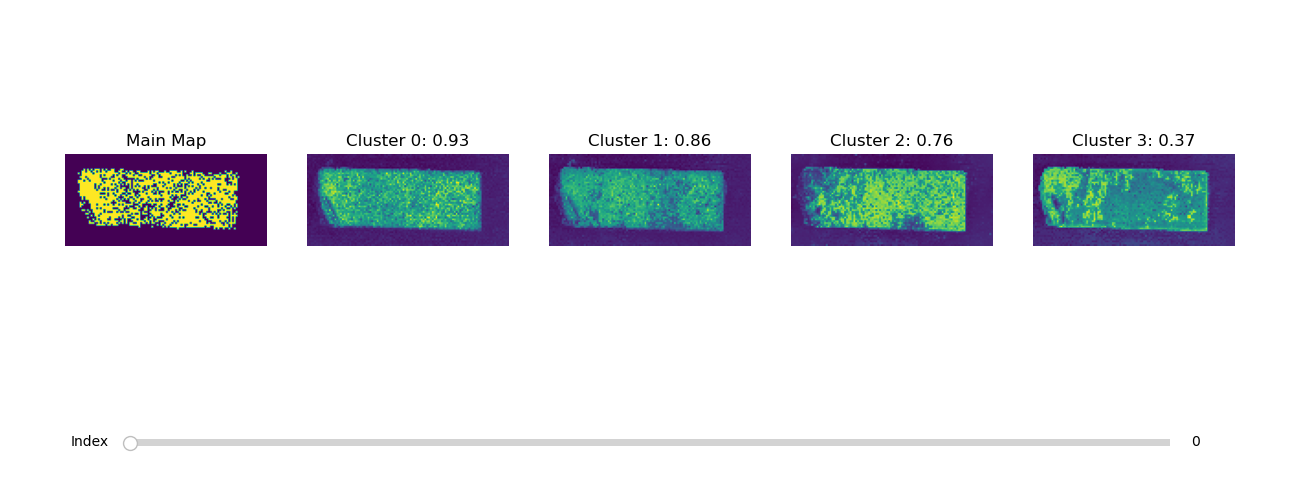

In [205]:
%matplotlib widget
# Create the figure and initial plots
fig, axes = plt.subplots(1, thresholded_clusters.shape[0] + 1, figsize=(13, 5))
plt.subplots_adjust(left=0.05, bottom=0.25, right=0.95, top=0.95)

# Plot the main new_map[i]
main_im = axes[0].imshow(maps_thres[0], cmap='viridis')
axes[0].set_title("Main Map")

# Remove x and y ticks for the main map
axes[0].axis('off')

# Plot the thresholded clusters
cluster_ims = []
for j in range(thresholded_clusters.shape[0]):
    cluster_im = axes[j + 1].imshow(clusters_reshaped[j], cmap='viridis')
    cluster_ims.append(cluster_im)
    axes[j + 1].set_title(f"Cluster {j}: {round(intersections_c[0, j],2)}")
    axes[j + 1].axis('off')  # Remove x and y ticks for each cluster plot

ax_slider = plt.axes([0.1, 0.1, 0.8, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(ax_slider, 'Index', 0, maps_thres.shape[0] - 1, valinit=0, valstep=1)

def update(val):
    i = int(slider.val)
    main_im.set_data(maps_thres[i])
    
    for j, cluster_im in enumerate(cluster_ims):
        cluster_im.set_data(clusters_reshaped[j])
        axes[j + 1].set_title(f"Cluster {j}: {round(intersections_c[i, j],2)}")
    
    fig.canvas.draw_idle()

slider.on_changed(update)

plt.show()



In [206]:
from collections import defaultdict

# Create a dictionary to store unique entries and their counts
counts_dict = defaultdict(int)

for group in cluster_groups:
    counts_dict[tuple(group)] += 1

# Convert defaultdict to a regular dictionary
counts_dict = dict(counts_dict)

print(counts_dict)

{(0, 1, 2): 125, (1, 2): 8, (1,): 9, (0, 1): 7, (0, 1, 3): 49, (): 4}


In [207]:
# Create a new dictionary with names instead of indexes
named_counts_dict = {}

for indexes, count in counts_dict.items():
    if indexes == ():
        continue
    # Replace each index with the corresponding name from cluster_label
    else:
        named_keys = [cluster_label[index] for index in indexes]
        named_counts_dict[tuple(named_keys)] = count
sorted_items = sorted(named_counts_dict.items(), key=lambda x: x[1], reverse=True)

print(sorted_items)

[(('Si', 'Al', 'Li'), 125), (('Si', 'Al', 'Na'), 49), (('Al',), 9), (('Al', 'Li'), 8), (('Si', 'Al'), 7)]


(5, 50, 110)


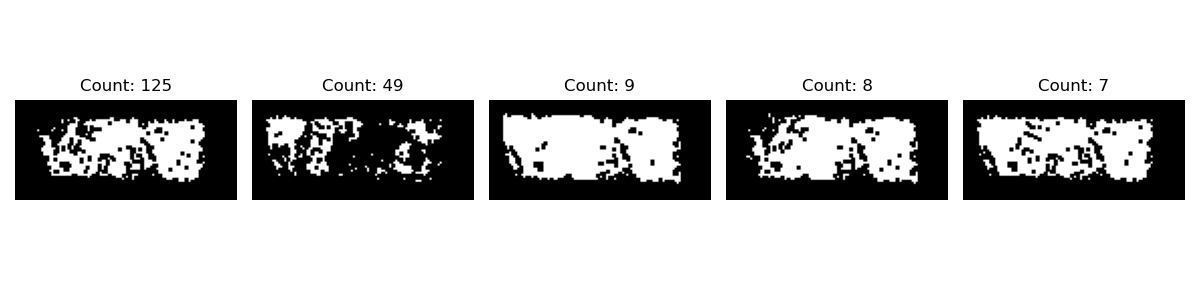

In [208]:

def calculate_intersection(indices):
    # Start with the first cluster's elements
    intersection = thresholded_clusters[indices[0]]
    
    # Apply np.logical_and across the selected clusters
    for index in indices[1:]:
        intersection = np.logical_and(intersection, thresholded_clusters[index])
    
    return intersection

# Take the top 4 entries (if there are at least 4)
top_four_entries = sorted_items[:5]

# Initialize an array to store the top four intersection maps
top_four_intersections = []

# Iterate through the top four entries
for names, count in top_four_entries:
    # Convert cluster names back to indices
    indices = [cluster_label.index(name) for name in names]
    
    # Calculate the intersection using np.logical_and
    intersection = calculate_intersection(indices)
    
    # Append the intersection map to the list
    top_four_intersections.append(intersection)

# Convert the list of intersections into a 3D numpy array (shape: (4, height, width))
top_four_intersections_array = np.array(top_four_intersections)

# Print the shape of the resulting array (optional)
print(top_four_intersections_array.shape)

# If you want to visualize the maps
fig, axes = plt.subplots(1, 5, figsize=(12, 3))  # 1 row, 4 columns for the 4 maps
for i, intersection in enumerate(top_four_intersections):
    axes[i].imshow(intersection, cmap='gray')
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f"Count: {top_four_entries[i][1]}")  # Set title with the count

plt.tight_layout()
plt.show()

primeiras duas são exclusivas e com counts muito mais elevados que as restantes, conto essas como os minerais principais

[]

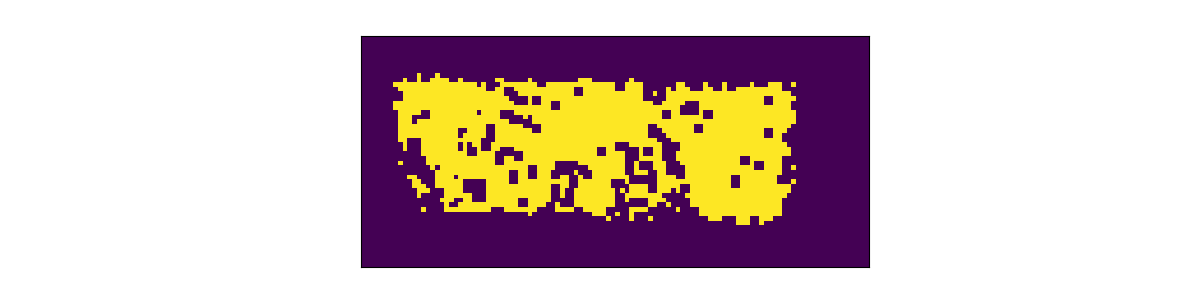

In [209]:
fig, axes = plt.subplots(1, figsize=(12, 3))  # 1 row, 4 columns for the 4 maps
combination=np.logical_or(top_four_intersections[0],top_four_intersections[1])
axes.imshow(combination)
axes.set_xticks([])
axes.set_yticks([])

algum dos elementos melhora?

[]

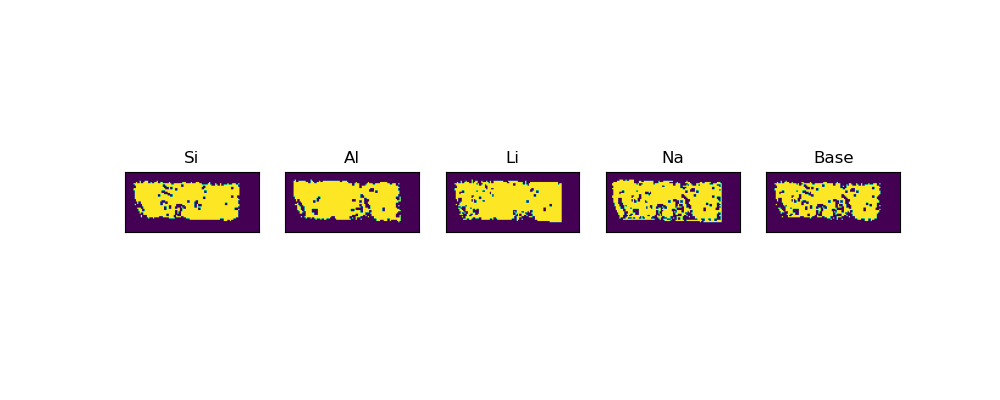

In [214]:
fig,ax=plt.subplots(1,n_clusters+1,figsize=(10,4))
base=np.logical_or(top_four_intersections[0],top_four_intersections[1])
for i in range(n_clusters):
    new=np.logical_or(base,thresholded_clusters[i])
    ax[i].imshow(new)
    ax[i].set_title(cluster_label[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

ax[-1].imshow(base)
ax[-1].set_title('Base')
ax[-1].set_xticks([])
ax[-1].set_yticks([])

silicio é o unico elemento que preenche a zona em falta, há mais um mineral com silicio mas sem nenhum dos outros elementos

### com 5 clusters

In [172]:
peaks=scipy.signal.find_peaks(sums)[0]
sel_maps=[]
sel_wavs=[]
heights=sums[peaks]
for i in range(len(peaks)):
    if heights[i]>0.11:
        sel_maps.append(maps[peaks[i]])
        sel_wavs.append([wavelengths[peaks[i]]])

sel_maps=np.array(sel_maps)
sel_maps=sel_maps.reshape(-1,maps.shape[1],maps.shape[2])

In [173]:
# para os mapas que estão dentro dos parametros da fft retirar os que tem sinal fora da rocha
sel_maps_f=sel_maps.reshape(-1,sel_maps.shape[1]*sel_maps.shape[2])
thresholds=np.array([threshold_otsu(sel_maps_f[i]) for i in range(sel_maps.shape[0])])
final_masks=[]
for map in range(len(thresholds)):
    c_mask=np.zeros(sel_maps_f.shape[1])
    for i in range(sel_maps_f.shape[1]):
        if sel_maps_f[map,i]>thresholds[map]:
            c_mask[i]=1
    final_masks.append(c_mask)

final_masks=np.array(final_masks).reshape(-1,sel_maps.shape[1],sel_maps.shape[2])


new_maps=[]
edge=[]
for w in tqdm(range(final_masks.shape[0])):
    current_map=final_masks[w,:,:]
    pixel_sum=np.sum(current_map[43:,:])
    if pixel_sum <1:
        new_maps.append(sel_maps[w,:,:])
new_maps=np.array(new_maps)
print(sel_maps.shape)
print(new_maps.shape)

100%|██████████| 180/180 [00:00<00:00, 4348.21it/s]

(180, 50, 110)
(22, 50, 110)


In [174]:
edge_maps=[]
for w in tqdm(range(new_maps.shape[0])):
    current_map=new_maps[w,:,:]*255
    edges = feature.canny(current_map,sigma=1.5)
    edge_maps.append(edges)
edge_maps=np.array(edge_maps)
texture_maps=[]

for w in tqdm(range(new_maps.shape[0])):
    current_map=new_maps[w,:,:]
    filt_real, filt_imag = gabor(current_map, frequency=0.6) #lower f, more sensitivty to detail
    texture_maps.append(filt_real)
texture_maps=np.array(texture_maps)


100%|██████████| 22/22 [00:00<00:00, 1771.72it/s]


In [177]:
n_clusters=5
kmeans = sklearn.cluster.KMeans(n_clusters = n_clusters,random_state=0)
 
new_features=new_maps*500+edge_maps*10+texture_maps*400
features=new_features.reshape(-1,maps.shape[2]*maps.shape[1])
a=kmeans.fit_predict(features)
labels = kmeans.labels_
clusters_c = np.array(kmeans.cluster_centers_)

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


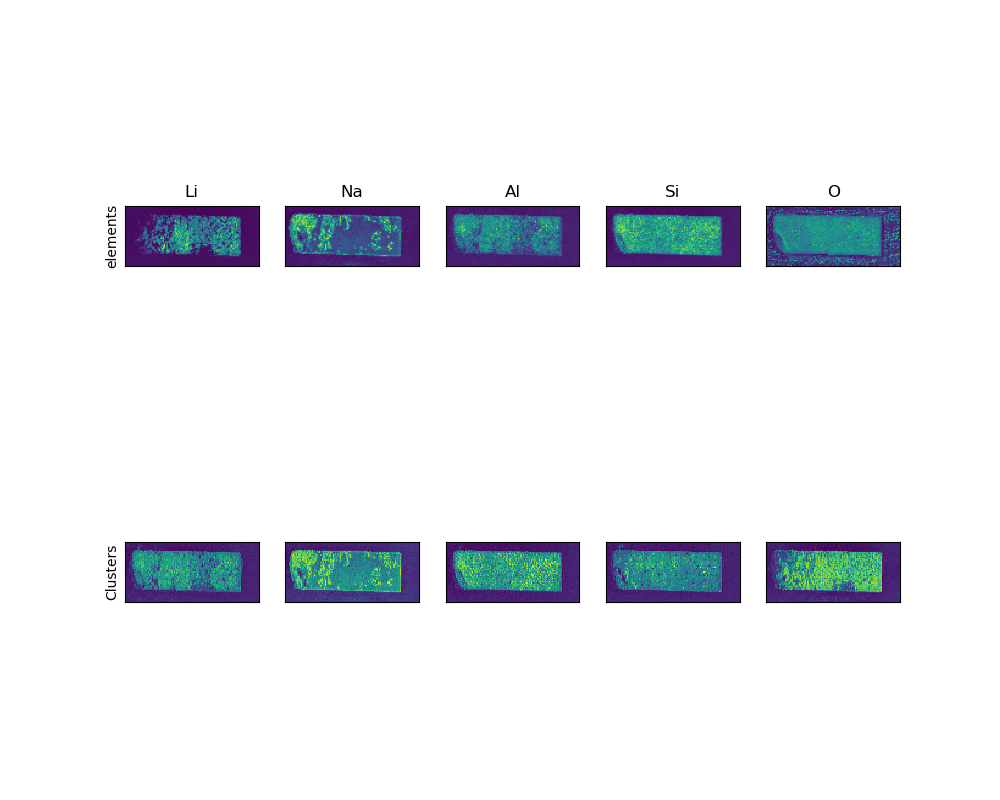

In [178]:
fig,ax=subplots(2,n_clusters,figsize=(10,8))
for i in range(n_clusters):
    if i<len(el):
        wav=find_index(wavelengths,el[i])
        ax[0,i].imshow(maps[wav,:,:])
        ax[0,i].set_title(el_n[i])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[0,0].set_ylabel('elements')
    ax[1,0].set_ylabel('Clusters')

    ax[1,i].imshow(clusters_c[i].reshape(maps.shape[1], maps.shape[2]), interpolation = 'none')

In [183]:
#definir area da imagem para thresholding
#cluster_label=['Al','Na','Si','O','Li']
cluster_label=['Al','Na','Si','O','Li']
clusters_reshaped=clusters_c.reshape(-1,maps.shape[1], maps.shape[2])
clusters_reshaped.shape

(5, 50, 110)

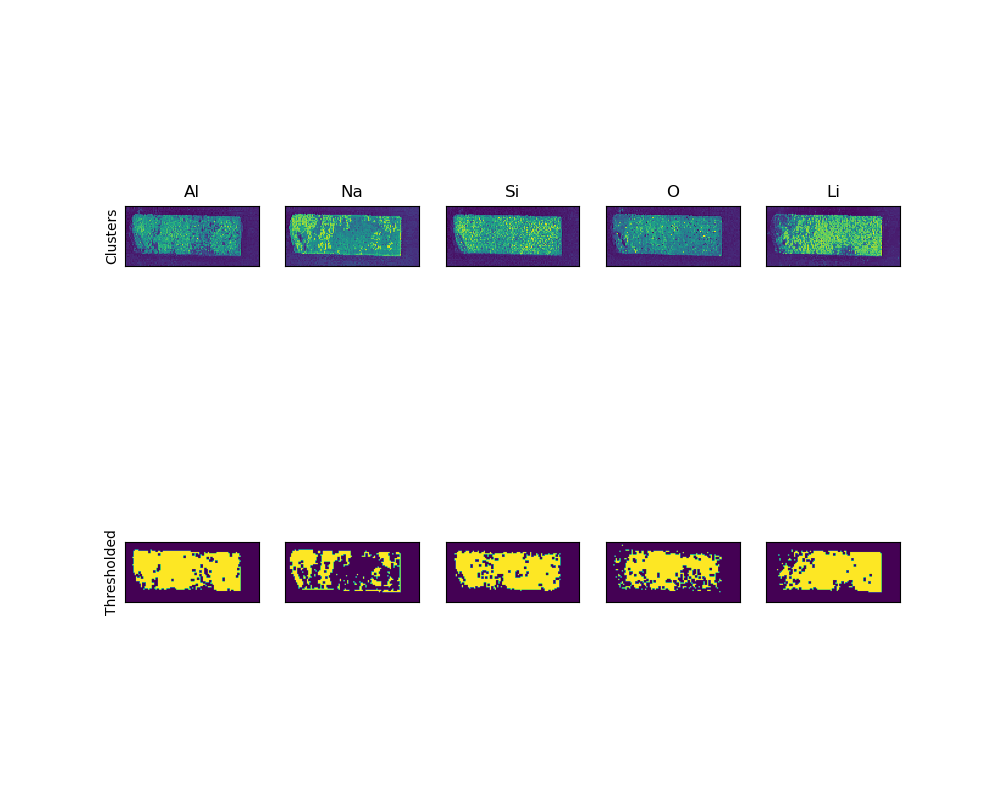

In [188]:
fig,ax=subplots(2,n_clusters,figsize=(10,8))
thresholded_clusters=[]

for i in range(n_clusters):
    ax[0,i].imshow(clusters_reshaped[i], interpolation = 'none')
    ax[0,i].set_title(cluster_label[i])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[0,0].set_ylabel('Clusters')


    t=threshold_otsu(clusters_reshaped[i,8:36,20:90])# a threshold tem de ser definida só dentro da amostra
    cluster_t=clusters_reshaped[i].copy()>t
    cleaned_map = erosion(cluster_t, square(1))
    cleaned_map = closing(cleaned_map, square(2))  # disk(2) or other sizes
    thresholded_clusters.append(cleaned_map)
    ax[1,i].imshow(cleaned_map)


    ax[1,0].set_ylabel('Thresholded')
thresholded_clusters=np.array(thresholded_clusters)

In [133]:
# O nao preenche bem

['Si', 'Al', 'Li', 'Na']